In [2]:
import requests
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import datetime
import os
import re

In [3]:
#mount drive
from google.colab import drive
Drive=drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path = "/content/gdrive/My Drive/GG_Project_NLP/Data/commit_messages/new_commits_df_14dec.csv"
df = pd.read_csv(path)
df['date_time'] = pd.to_datetime(df['date_time'])
#df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683326 entries, 0 to 1683325
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   proj_name    1683325 non-null  object        
 1   date_time    1683325 non-null  datetime64[ns]
 2   author_name  1682145 non-null  object        
 3   email_id     761401 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 51.4+ MB


In [7]:
df.head()

,proj_name,date_time,author_name,email_id
0,accumulo,2020-12-02 21:41:00,dependabot[bot],<49699333+dependabot[bot]@users.noreply.github...
1,accumulo,2020-12-03 14:03:00,Christopher Tubbs,<ctubbsii@apache.org>
2,accumulo,2020-12-04 16:02:00,Dave Marion,<dlmarion@apache.org>
3,accumulo,2020-11-02 15:14:00,Mike Miller,<mmiller@apache.org>
4,accumulo,2020-11-03 00:53:00,Christopher Tubbs,<ctubbsii@apache.org>


In [10]:
#Some cleaning to drop NaN values in author_name and email_id columns and to drop bot names

df=df.drop_duplicates(subset=['proj_name', 'date_time','author_name','email_id'], keep='last')

new_df=df.dropna()
new_df['author_name'] = new_df['author_name'].str.lower()
replace_str = [ ",", "\):", "/", "\\", "*", "$", "`", "\'", "\"", "|", ",", " \)", "=", "+", "#", "=", "\[", "\]", "?", "\(\)\;", "\);", ";"]
for i in replace_str:
  new_df['author_name'] = new_df['author_name'].str.replace(i,"")

new_df['author_name'] = new_df['author_name'].str.replace("  "," ")


bot_str = ['\[bot\]', 'buildbot', 'dependabot','nicerobot', 'github bot', '-bot', 'github actions bot', 'mergebot', 'renovate bot', 'automated github actions', 'auth of last commit', '4 immediate children', 'utf-8', 'entry get author', 'gg@localhost']
for i in bot_str:
    new_df = new_df.drop(new_df[new_df['author_name'].str.contains(i)].index)
    new_df = new_df.drop(new_df[new_df['author_name']=='root'].index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

(758657, 4)

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758657 entries, 1 to 1683325
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   proj_name    758657 non-null  object        
 1   date_time    758657 non-null  datetime64[ns]
 2   author_name  758657 non-null  object        
 3   email_id     758657 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 48.9+ MB


In [11]:
new_df.head()

,proj_name,date_time,author_name,email_id
1,accumulo,2020-12-03 14:03:00,christopher tubbs,<ctubbsii@apache.org>
2,accumulo,2020-12-04 16:02:00,dave marion,<dlmarion@apache.org>
3,accumulo,2020-11-02 15:14:00,mike miller,<mmiller@apache.org>
4,accumulo,2020-11-03 00:53:00,christopher tubbs,<ctubbsii@apache.org>
5,accumulo,2020-11-03 17:39:00,keith turner,<kturner@apache.org>


In [13]:
df=new_df

In [14]:
# Find number of unique emails and author names per project
df_emailID=df.groupby('proj_name')['email_id'].nunique()
df_authorName = df.groupby('proj_name')['author_name'].nunique()

In [15]:
df_emailID=df_emailID.reset_index()
df_authorName=df_authorName.reset_index()


df_count=pd.concat([df_authorName, df_emailID.drop(columns=['proj_name'])],axis=1) 
df_count

,proj_name,author_name,email_id
0,accumulo,167,190
1,activemq,324,345
2,age,4,4
3,airavata,100,108
4,airflow,788,817
...,...,...,...
228,xerces,1,1
229,xmlgraphics,2,3
230,yetus,51,54
231,zeppelin,444,455


In [34]:
df_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   proj_name    233 non-null    object
 1   author_name  233 non-null    int64 
 2   email_id     233 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.6+ KB


In [16]:
# find statistics (min,max,mean,std) for number of emails and author names per project
df_count[['author_name','email_id']].agg(['min', 'max', 'mean', 'std']).round(decimals=2) 

,author_name,email_id
min,1.00,1.00
max,2051.00,2206.00
mean,122.58,133.59
std,211.22,226.57


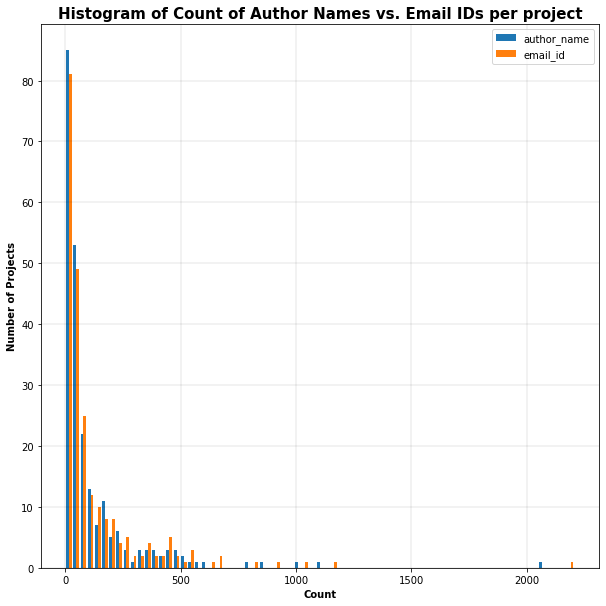

In [19]:
import matplotlib.pyplot as plt

# Plot Histogram of author name count and email ID count per project

hist=plt.hist([df_authorName['author_name'],df_emailID['email_id']], bins = 'auto',label=['author_name','email_id'])
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.ylabel('Number of Projects', fontweight='bold')
plt.xlabel('Count', fontweight='bold')
plt.title('Histogram of Count of Author Names vs. Email IDs per project', fontweight='bold',fontsize =15)
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


In [31]:
#find project with Max author_name
print(df_count.loc[df_count['author_name']==2051])
# Remove this project because it is an outlier
df_count_new=df_count.loc[df_count['proj_name']!='spark']

    proj_name  author_name  email_id
183     spark         2051      2206


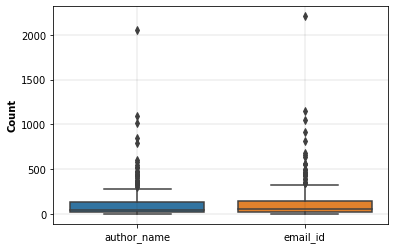

In [32]:
# Box Plot
import seaborn as sns
%matplotlib inline
sns.boxplot(data=df_count[['author_name','email_id']])
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.ylabel('Count',fontweight='bold')
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

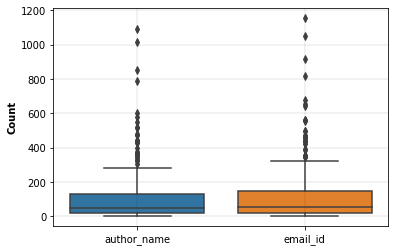

In [33]:
# Box Plot without the outlier project Spark with Max author_name
import seaborn as sns
%matplotlib inline
sns.boxplot(data=df_count_new[['author_name','email_id']])
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.ylabel('Count',fontweight='bold')
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

In [35]:
# Read the CSV created from JSON files to have a ground truth for number of unique author names per project

com = pd.read_csv("/content/gdrive/MyDrive/GG_Project_NLP/Data/commit_messages/json_data_updated_13dec_v3.csv")

In [46]:
com=com[['user_ids','author_name','project']]
com.head()

,user_ids,author_name,project
0,acordova,aaron michael cordova,accumulo
1,adamjshook,adam j shook,accumulo
2,afuchs,adam fuchs,accumulo
3,alerman,adam lerman,accumulo
4,knarendran,karthick narendran,accumulo


In [47]:
# Find number of unique emails and author names per project in JSON file
com_emailID=com.groupby('project')['user_ids'].nunique()
com_authorName = com.groupby('project')['author_name'].nunique()
com_emailID=com_emailID.reset_index()
com_authorName=com_authorName.reset_index()

com_count=pd.concat([com_authorName, com_emailID.drop(columns=['project'])],axis=1) 
com_count

,project,author_name,user_ids
0,accumulo,108,54
1,activemq,63,63
2,age,9,9
3,airavata,41,41
4,airflow,35,35
...,...,...,...
267,xmlgraphics,21,21
268,yetus,12,12
269,yunikorn,19,19
270,zeppelin,22,22


In [49]:
import numpy as np

#compare number of unique emai_ids/author_names scraped from commit messages to number of unique author_names found in JSON file
df_count['author_name_json']=com_count['author_name']
comparison_column = df_count[(df_count["author_name"] > df_count["author_name_json"]) | (df_count["email_id"] > df_count["author_name_json"])]

In [50]:
# Print total number of projects with author_name/email_id count greater than the JSON file
comparison_column.shape[0]

163